#### 1. Imports

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import geo

#### 2. Reading Data

In [67]:
data = pd.read_csv('data_bc.csv')
# dataBC.head()

C:\Users\bubly\AppData\Local\Temp\ipykernel_16716\3965932341.py:1: DtypeWarning: Columns (42,93,259) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data_bc.csv')


#### 3. Data Filtering (for smaller dataset)

In [68]:
dataBC = data[data['addressRegion'] == 'BC']
dataBC = dataBC.sort_values(by='addressLocality')

dataBC = dataBC.filter([
    'streetAddress',
    'addressLocality',
    'addressRegion',
    'postalCode',
    'latitude',
    'longitude',
    'price',
    'property-beds',
    'property-baths',
    'property-sqft',
    'Garage',
    'Property Type', #Agricultural, Condo, Condo/Townhouse, Duplex, Manufactured Home, Mobile Home, MultiFamily, Single Family, Townhome, Vacant Land
    'Square Footage',
    ])
# data_bc_single_family = dataBC[dataBC['Property Type'] == 'Single Family']
property_types = ['Single Family','Condo', 'Townhome', 'MultiFamily']
data_bc_single_family = dataBC[dataBC['Property Type'].isin(property_types)]

In [69]:
metro_vancouver_cities = [
    "Vancouver", "Burnaby", "Richmond", "Surrey", "Coquitlam",
    "North Vancouver", "West Vancouver", "New Westminster",
    "Delta", "Port Coquitlam", "Port Moody", "Langley"
]
data_bc_single_family = data_bc_single_family[data_bc_single_family['addressLocality'].isin(metro_vancouver_cities)]

In [70]:
# --- sample was used as a small test dataset to run our code without having to wait a long time ---#
# sample = data_bc_single_family.head()
# sample

In [71]:
# Now that we have our cleaned up data from the csv file, we can save it and load it from our new file
data_bc_single_family.to_csv('data_bc_1.csv')

##### 3.1. Getting Distances (using geo.py)

In [72]:
lat_lon_array = data_bc_single_family[['latitude', 'longitude']].to_numpy()
# lat_lon_array

This code is run originally before we have created 'amenities_distances.csv'/'amenities_distances.json'. Since it has to run multiple API calls, it takes the longest and acts as a bottleneck for our project. Once we've completed running it the first time, we can store our .csv/.json file and simply load it into our document below.

We also modified it to cache our results in case a user did not want to store results as new .csv file. This creates a json file that can be read on repeated runs to make sure the program doesn't get stuck on this part.

In [73]:
results = []
for lat, lon in lat_lon_array:
    amenities = geo.get_specific_amenities_cached(lat, lon, radius=3000)
    conv_distance = []
    transit_distance = []
    school_distance = []

    if amenities:
        for a in amenities:
            dist = geo.haversine(lat, lon, a['latitude'], a['longitude'])
            if a.get('shop') in ['convencince', 'grocery']:
                conv_distance.append(dist)
            elif a.get('amenity') in ['bus_station', 'subway_station', 'railway_station']:
                transit_distance.append(dist)
            elif a.get('amenity') in ['school', 'university']:
                school_distance.append(dist)
            
    results.append({
        'latitude': lat,
        'longitude': lon,
        'avg_convenience_dist': np.mean(conv_distance),
        'avg_transit_distance': np.mean(transit_distance),
        'avg_school_distance': np.mean(school_distance)
    })

results_df = pd.DataFrame(results)
results_df

c:\Users\bubly\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bubly\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,latitude,longitude,avg_convenience_dist,avg_transit_distance,avg_school_distance
0,49.284733,-122.979824,NaN,NaN,2.351229
1,49.232249,-122.921209,NaN,2.485465,NaN
2,49.249691,-122.894086,NaN,1.020296,NaN
3,49.235055,-122.950665,2.691901,NaN,2.436122
4,49.226336,-123.006607,1.946606,NaN,1.542220
...,...,...,...,...,...
13353,49.326649,-123.134209,1.597635,0.318176,1.837962
13354,49.331529,-123.141157,1.150848,0.537051,1.728082
13355,49.344583,-123.219085,NaN,NaN,NaN
13356,49.238982,-123.139048,1.461060,NaN,1.437178


In [74]:
# Merge our results to our original dataframe to get all our data into one
data_bc_single_family = data_bc_single_family.merge(
    results_df,
    how='left',
    on=['latitude', 'longitude']
)

In [75]:
geo.save_cache()

In [76]:
# save our results from above into files we can load after
results_df.to_json("amenities_distances.json", orient="records")
results_df.to_csv('amenities_distances.csv', index=False)

Below is the code we can use if we already have our 'amenities_distances.csv'/'amenities_distances.json' files. We will likely use this in our executable .py file

In [77]:
#Not in use since the results_df is currently cached

# def enrich_main_data(main_df, amenities_df):
#     return main_df.merge(
#         amenities_df,
#         on=['latitude', 'longitude'],
#         how='left'
#     )

# amenities_data = pd.read_csv('amenities_distances.csv')

# data_bc_single_family = enrich_main_data(data_bc_single_family, amenities_data)

In [78]:
# data_bc_single_family

##### 3.2. Price-to-Income Ratio

In [79]:
# print(data_bc_single_family['price'])

In [80]:
censusdata = pd.read_csv('CensusProfile2021.csv', encoding='latin1')
filtered_df = censusdata[censusdata.iloc[:, 0].str.contains("Income of individuals in", case=False, na=False)]
final_df = filtered_df[filtered_df.iloc[:, 1].str.contains("average|median", case=False, na=False)]
final_2020_df = final_df[
    final_df.iloc[:, 0].str.contains("2020", na=False) |
    final_df.iloc[:, 1].str.contains("2020", na=False)
]
final_2020_df = final_2020_df[final_2020_df.iloc[:, 1].str.contains("Median employment income in 2020 for full-year full-time workers in 2020", case=False, na=False)] 
# print(final_2020_df)
#final_2020_df.to_csv('CensusData_cleaned')
final_2020_df['Unnamed: 2'] = pd.to_numeric(final_2020_df['Unnamed: 2'], errors='coerce')
median_income = final_2020_df['Unnamed: 2'].iloc[0]

In [81]:

data_bc_single_family['Price-to-income Ratio'] = data_bc_single_family['price'] / median_income 
# data_bc_single_family

#### 4. Normalizing Data

In [82]:
# Started by making a copy to save our earlier df. This would not be required in our final .py file
data_bc_all_values = data_bc_single_family.copy()
# data_bc_all_values.head()

In [83]:
# Display the current 'Garage' and 'property-sqft' value types to know what we're converting from
print(data_bc_all_values['Garage'].dtype)
print(data_bc_all_values['property-sqft'].dtype)

object
object


Below, we convert all types to float64, and fill in any 'NaN' values. This way, our data is numerical and can be scaled/normalized the same way.

In [84]:
features = [
            'price',
            'property-beds', 
            'property-baths', 
            'property-sqft', 
            'Garage',
            'Property Type', 
            'avg_convenience_dist', 
            'avg_transit_distance', 
            'avg_school_distance', 
            'Price-to-income Ratio',
        ]
data_bc_all_values['property-sqft'] = (data_bc_all_values['property-sqft'].str.replace(',', '', regex=False).astype(float))
data_bc_all_values['property-sqft'] = pd.to_numeric(data_bc_all_values['property-sqft'], errors='coerce')
data_bc_all_values['Property Type'] = data_bc_all_values['Property Type'].map({'Condo': 0.25, 'Townhome': 0.5, 'Single Family': 0.75, 'MultiFamily': 1})

convenience_max = data_bc_all_values['avg_convenience_dist'].max()
transit_max = data_bc_all_values['avg_transit_distance'].max()
school_max = data_bc_all_values['avg_school_distance'].max()
data_bc_all_values['avg_convenience_dist'] = data_bc_all_values['avg_convenience_dist'].fillna(convenience_max * 1.1)
data_bc_all_values['avg_transit_distance'] = data_bc_all_values['avg_transit_distance'].fillna(transit_max * 1.1)
data_bc_all_values['avg_school_distance'] = data_bc_all_values['avg_school_distance'].fillna(school_max * 1.1)
data_bc_all_values['Garage'] = np.where(data_bc_all_values['Garage'] == 'Yes', 1, 0)


In [85]:
# testing to see if all our data is numerical
data_bc_all_values

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,2515.0,0,0.75,"2,515 SQFT",3.304471,3.303640,2.351229,33.661538
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,1790.0,0,0.50,"1,790 SQFT",3.304471,2.485465,3.302994,19.230769
2,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,1790.0,0,0.50,"1,790 SQFT",3.304471,2.485465,3.302994,19.230769
3,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950.0,0,0.25,950 SQFT,3.304471,1.020296,3.302994,15.046154
4,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950.0,0,0.25,950 SQFT,3.304471,1.020296,3.302994,15.046154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51827,"14E 328 TAYLOR WAY, West Vancouver, BC V7T 2Y4",West Vancouver,BC,V7T 2Y4,49.326649,-123.134209,1245000.0,2.0,2.0,1349.0,0,0.25,"1,349 SQFT",1.597635,0.318176,1.837962,19.153846
51828,"959 ANDERSON CRESCENT, West Vancouver, BC V7T 1S6",West Vancouver,BC,V7T 1S6,49.331529,-123.141157,4800000.0,4.0,4.0,3354.0,0,0.75,"3,354 SQFT",1.150848,0.537051,1.728082,73.846154
51829,"3722 SOUTHRIDGE PLACE, West Vancouver, BC V7V 3H8",West Vancouver,BC,V7V 3H8,49.344583,-123.219085,4270000.0,5.0,5.0,3650.0,0,0.75,"3,650 SQFT",3.304471,3.303640,3.302994,65.692308
51830,"36 BEACH DRIVE, West Vancouver, BC V0N 3Z1",West Vancouver,BC,V0N 3Z1,49.238982,-123.139048,1958000.0,3.0,3.0,2406.0,0,0.50,"2,406 SQFT",1.461060,3.303640,1.437178,30.123077


In [86]:
# use a MinMaxScaler() to scale all our values
scaler = MinMaxScaler()
data_scaled = data_bc_all_values.copy()

# since lower is better, we inverse our price and our distance values before scoring
data_scaled["price"] = 1 - data_scaled['price']
data_scaled['avg_convenience_dist'] = 1 - data_scaled['avg_convenience_dist']
data_scaled['avg_transit_distance'] = 1 - data_scaled['avg_transit_distance']
data_scaled['avg_school_distance'] = 1 - data_scaled['avg_school_distance']

data_scaled[features] = scaler.fit_transform(data_bc_all_values[features])
data_scaled = data_scaled.dropna()
data_scaled

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,0.037175,0.3125,0.250000,0.006413,0.0,0.666667,"2,515 SQFT",1.000000,1.000000,0.704085,0.037175
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,0.021222,0.1875,0.250000,0.004563,0.0,0.333333,"1,790 SQFT",1.000000,0.747657,1.000000,0.021222
2,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,0.021222,0.1875,0.250000,0.004563,0.0,0.333333,"1,790 SQFT",1.000000,0.747657,1.000000,0.021222
3,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,0.016596,0.1875,0.166667,0.002421,0.0,0.000000,950 SQFT,1.000000,0.295766,1.000000,0.016596
4,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,0.016596,0.1875,0.166667,0.002421,0.0,0.000000,950 SQFT,1.000000,0.295766,1.000000,0.016596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51827,"14E 328 TAYLOR WAY, West Vancouver, BC V7T 2Y4",West Vancouver,BC,V7T 2Y4,49.326649,-123.134209,0.021137,0.1250,0.166667,0.003438,0.0,0.000000,"1,349 SQFT",0.472733,0.079217,0.544505,0.021137
51828,"959 ANDERSON CRESCENT, West Vancouver, BC V7T 1S6",West Vancouver,BC,V7T 1S6,49.331529,-123.141157,0.081598,0.2500,0.333333,0.008553,0.0,0.666667,"3,354 SQFT",0.334714,0.146723,0.510342,0.081598
51829,"3722 SOUTHRIDGE PLACE, West Vancouver, BC V7V 3H8",West Vancouver,BC,V7V 3H8,49.344583,-123.219085,0.072584,0.3125,0.416667,0.009308,0.0,0.666667,"3,650 SQFT",1.000000,1.000000,1.000000,0.072584
51830,"36 BEACH DRIVE, West Vancouver, BC V0N 3Z1",West Vancouver,BC,V0N 3Z1,49.238982,-123.139048,0.033263,0.1875,0.250000,0.006135,0.0,0.333333,"2,406 SQFT",0.430543,1.000000,0.419897,0.033263


#### 5. Weighing and Scoring

In [87]:
score_features = [
            'price',
            'property-beds', 
            'property-baths', 
            'property-sqft', 
            'Garage',
            'Property Type', 
            'avg_convenience_dist', 
            'avg_transit_distance', 
            'avg_school_distance', 
            'Price-to-income Ratio',
        ]

# currently setting all our features to hold equal weight. This can be adjusted if needed. Maybe user input?
weights = np.array([1/len(score_features)] * len(score_features))
# again, copied to save our original, but not needed in final .py file
data_scored = data_scaled.copy()

data_scored['Score'] = data_scaled[score_features].dot(weights)
data_scored.sort_values(by='Score', ascending=False, inplace=True)
data_scored

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio,Score
51140,"3330 RADCLIFFE AVENUE, West Vancouver, BC V7V 1G6",West Vancouver,BC,V7V 1G6,49.340359,-123.208444,1.000000,0.3125,0.583333,0.025362,0.0,0.666667,"9,944 SQFT",1.000000,1.000000,1.000000,1.000000,0.658786
46562,"4838 BELMONT AVENUE, Vancouver, BC V6T 1A9",Vancouver,BC,V6T 1A9,49.274890,-123.221204,0.846933,0.3125,0.666667,0.031652,0.0,0.666667,"12,410 SQFT",1.000000,1.000000,0.635906,0.846933,0.600726
45887,"4788 BELMONT AVENUE, Vancouver, BC V6T 1A9",Vancouver,BC,V6T 1A9,49.274912,-123.219831,0.491273,0.4375,1.000000,0.025702,0.0,0.666667,"10,077 SQFT",1.000000,1.000000,0.641566,0.491273,0.575398
18598,"828 BEACHVIEW DRIVE, North Vancouver, BC V7G 1R1",North Vancouver,BC,V7G 1R1,49.313394,-122.949037,0.238067,0.5625,1.000000,0.033066,0.0,0.666667,"12,964 SQFT",1.000000,1.000000,1.000000,0.238067,0.573837
22578,"14791 WESTMINSTER HIGHWAY, Richmond, BC V6V 1A4",Richmond,BC,V6V 1A4,49.170036,-123.058770,0.336710,0.5000,1.000000,0.039075,0.0,0.666667,"15,320 SQFT",1.000000,1.000000,0.849233,0.336710,0.572839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51762,"309 1363 CLYDE AVENUE, West Vancouver, BC V7T 2W9",West Vancouver,BC,V7T 2W9,49.329062,-123.153651,0.013875,0.1250,0.083333,0.002089,0.0,0.000000,820 SQFT,0.044007,0.325558,0.449409,0.013875,0.105715
51353,"206 1363 CLYDE AVENUE, West Vancouver, BC V7T 2W9",West Vancouver,BC,V7T 2W9,49.329062,-123.153651,0.013552,0.1250,0.083333,0.002000,0.0,0.000000,785 SQFT,0.044007,0.325558,0.449409,0.013552,0.105641
51352,"206 1363 CLYDE AVENUE, West Vancouver, BC V7T 2W9",West Vancouver,BC,V7T 2W9,49.329062,-123.153651,0.013552,0.1250,0.083333,0.002000,0.0,0.000000,785 SQFT,0.044007,0.325558,0.449409,0.013552,0.105641
51312,"603 1420 DUCHESS AVENUE, West Vancouver, BC V7...",West Vancouver,BC,V7T 1H8,49.329449,-123.154866,0.011511,0.0625,0.083333,0.002523,0.0,0.000000,990 SQFT,0.033608,0.354930,0.455907,0.011511,0.101582


In [88]:
#as a last step, we remove any duplicates in our data

data_scored = data_scored.drop_duplicates()
data_scored

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio,Score
51140,"3330 RADCLIFFE AVENUE, West Vancouver, BC V7V 1G6",West Vancouver,BC,V7V 1G6,49.340359,-123.208444,1.000000,0.3125,0.583333,0.025362,0.0,0.666667,"9,944 SQFT",1.000000,1.000000,1.000000,1.000000,0.658786
46562,"4838 BELMONT AVENUE, Vancouver, BC V6T 1A9",Vancouver,BC,V6T 1A9,49.274890,-123.221204,0.846933,0.3125,0.666667,0.031652,0.0,0.666667,"12,410 SQFT",1.000000,1.000000,0.635906,0.846933,0.600726
45887,"4788 BELMONT AVENUE, Vancouver, BC V6T 1A9",Vancouver,BC,V6T 1A9,49.274912,-123.219831,0.491273,0.4375,1.000000,0.025702,0.0,0.666667,"10,077 SQFT",1.000000,1.000000,0.641566,0.491273,0.575398
18598,"828 BEACHVIEW DRIVE, North Vancouver, BC V7G 1R1",North Vancouver,BC,V7G 1R1,49.313394,-122.949037,0.238067,0.5625,1.000000,0.033066,0.0,0.666667,"12,964 SQFT",1.000000,1.000000,1.000000,0.238067,0.573837
22578,"14791 WESTMINSTER HIGHWAY, Richmond, BC V6V 1A4",Richmond,BC,V6V 1A4,49.170036,-123.058770,0.336710,0.5000,1.000000,0.039075,0.0,0.666667,"15,320 SQFT",1.000000,1.000000,0.849233,0.336710,0.572839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51820,"204 1331 MARINE DRIVE, West Vancouver, BC V7T 1B6",West Vancouver,BC,V7T 1B6,49.327921,-123.152812,0.028705,0.1250,0.166667,0.003125,0.0,0.000000,"1,226 SQFT",0.054008,0.301049,0.466762,0.028705,0.117402
51763,"309 1363 CLYDE AVENUE, West Vancouver, BC V7T 2W9",West Vancouver,BC,V7T 2W9,49.329062,-123.153651,0.013875,0.1250,0.083333,0.002089,0.0,0.000000,820 SQFT,0.044007,0.325558,0.449409,0.013875,0.105715
51353,"206 1363 CLYDE AVENUE, West Vancouver, BC V7T 2W9",West Vancouver,BC,V7T 2W9,49.329062,-123.153651,0.013552,0.1250,0.083333,0.002000,0.0,0.000000,785 SQFT,0.044007,0.325558,0.449409,0.013552,0.105641
51312,"603 1420 DUCHESS AVENUE, West Vancouver, BC V7...",West Vancouver,BC,V7T 1H8,49.329449,-123.154866,0.011511,0.0625,0.083333,0.002523,0.0,0.000000,990 SQFT,0.033608,0.354930,0.455907,0.011511,0.101582


#### 6. Results and Plotting

Our first and main plot is a boxplot that shows the median and the spread of scores categorized by city.

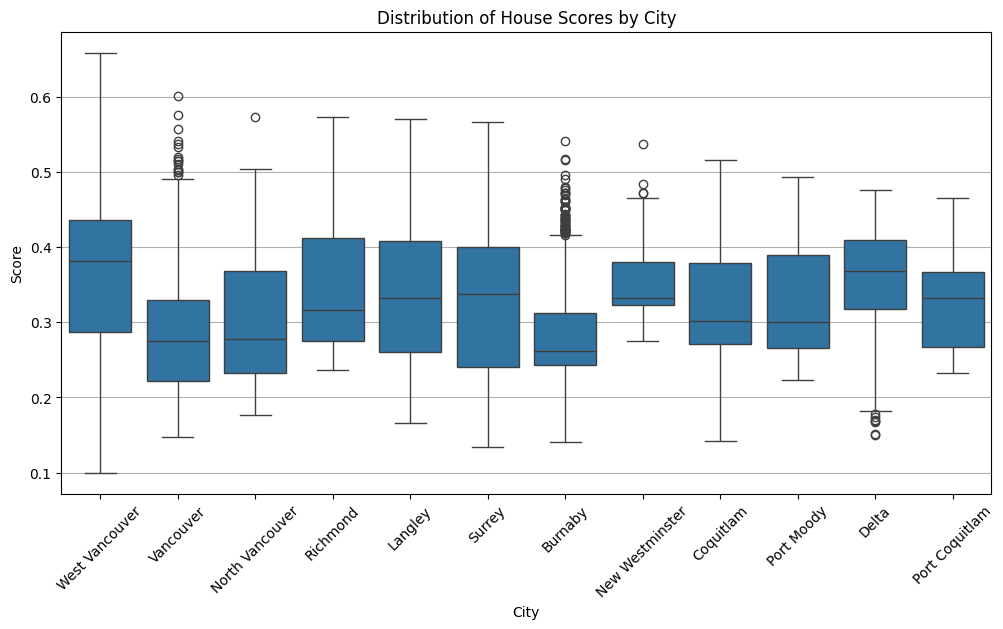

In [89]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='addressLocality', y='Score', data=data_scored)

plt.title('Distribution of House Scores by City')
plt.xlabel('City')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

The same graph as above but the x axis is sorted from lowest median to highest median

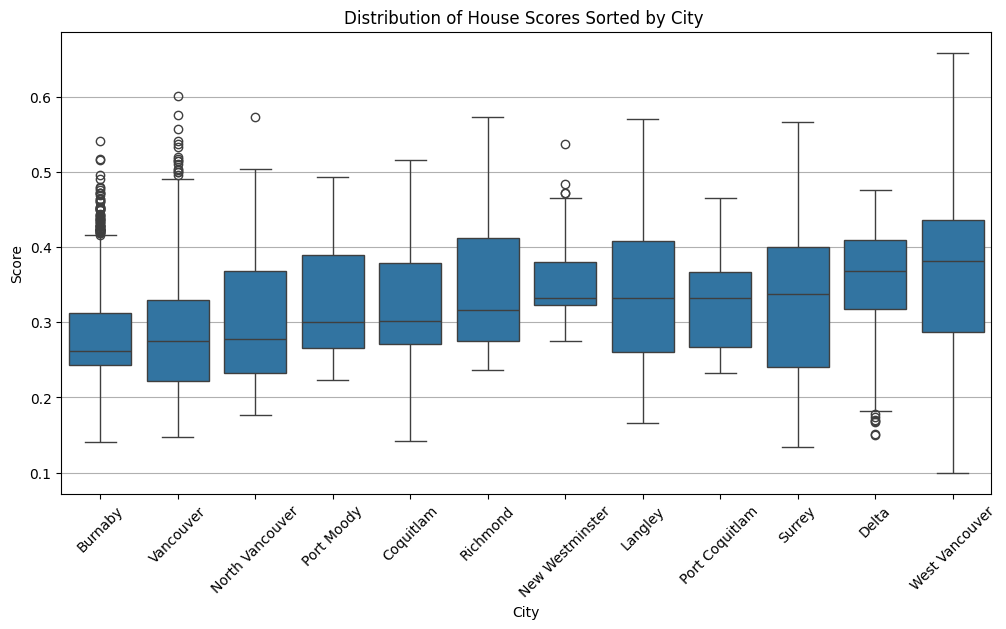

In [90]:
medians = data_scored.groupby('addressLocality')['Score'].median().sort_values()
cities = medians.index.to_list()

plt.figure(figsize=(12, 6))
sns.boxplot(x='addressLocality', y='Score', data=data_scored, order=cities)

plt.title('Distribution of House Scores Sorted by City ')
plt.xlabel('City')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

Our third graph is an OLS() representation of the significance of each feature on the score of an address. Price and Price-to-income Ratio greatly outweigh the other factors, so those (optionally) excluded from our results

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     2548.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:17:45   Log-Likelihood:                 30713.
No. Observations:               13268   AIC:                        -6.141e+04
Df Residuals:                   13260   BIC:                        -6.135e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0244 

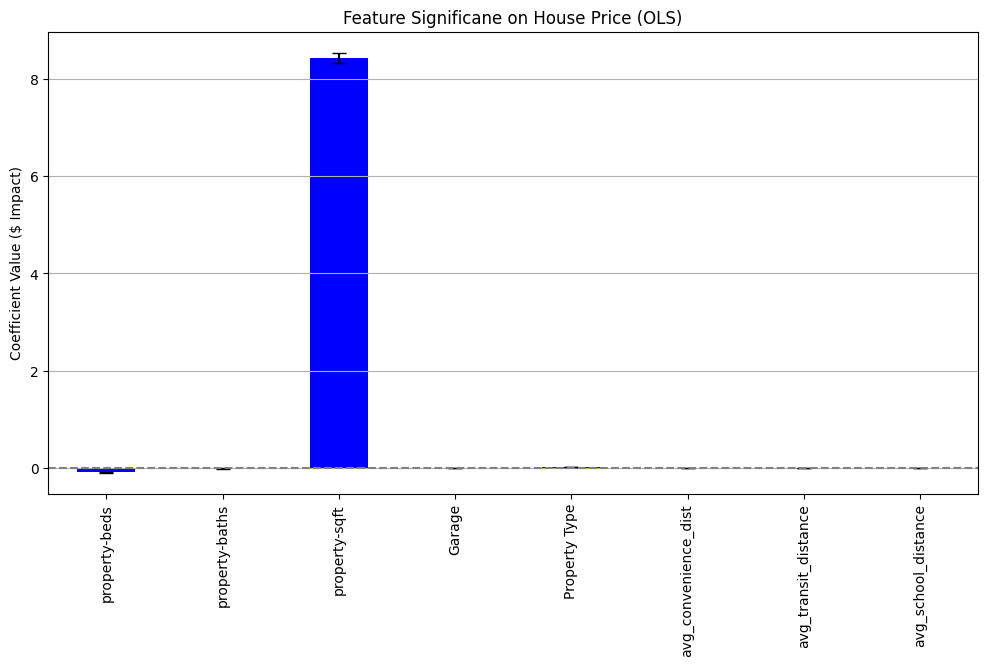

In [91]:
X = data_scored[[
                # 'price',
                'property-beds',
                'property-baths',
                'property-sqft',
                'Garage',
                'Property Type',
                'avg_convenience_dist',
                'avg_transit_distance',
                'avg_school_distance',
                # 'Price-to-income Ratio'
                ]]
X = sm.add_constant(X)
y = data_scored['price']

model = sm.OLS(y, X).fit()
coefficients = model.params.drop('const')
errors = model.bse.drop('const')
model_summary = model.summary()

print(model_summary)

plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar', yerr=errors, capsize=5, color='blue')
plt.title('Feature Significane on House Price (OLS)')
plt.ylabel('Coefficient Value ($ Impact)')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, axis='y')
plt.show()


From above, you can see that SqFt is much higher than the other factors. If we factor that out we can see a closer comparison of the other factors.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     1340.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:17:46   Log-Likelihood:                 28203.
No. Observations:               13268   AIC:                        -5.639e+04
Df Residuals:                   13261   BIC:                        -5.634e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0186 

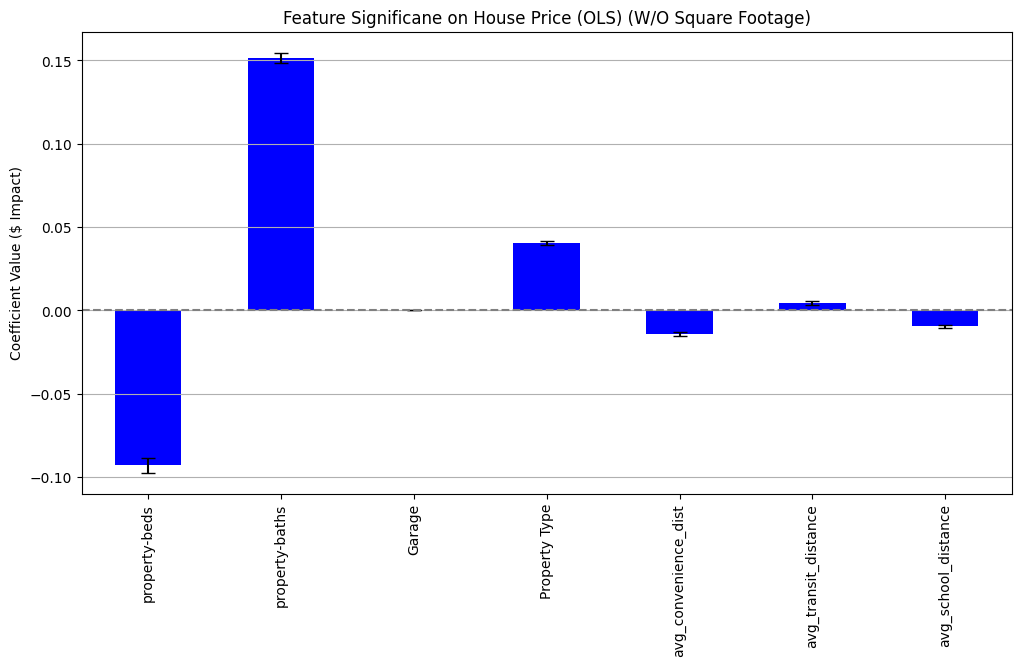

In [92]:
X = data_scored[[
                # 'price',
                'property-beds',
                'property-baths',
                # 'property-sqft',
                'Garage',
                'Property Type',
                'avg_convenience_dist',
                'avg_transit_distance',
                'avg_school_distance',
                # 'Price-to-income Ratio'
                ]]
X = sm.add_constant(X)
y = data_scored['price']

model = sm.OLS(y, X).fit()
coefficients = model.params.drop('const')
errors = model.bse.drop('const')
model_summary = model.summary()

print(model_summary)

plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar', yerr=errors, capsize=5, color='blue')
plt.title('Feature Significane on House Price (OLS) (W/O Square Footage)')
plt.ylabel('Coefficient Value ($ Impact)')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, axis='y')
plt.show()

This is extra idk if we're keeping this lol

Text(0.5, 1.0, 'SqFt vs Price with Regression Line')

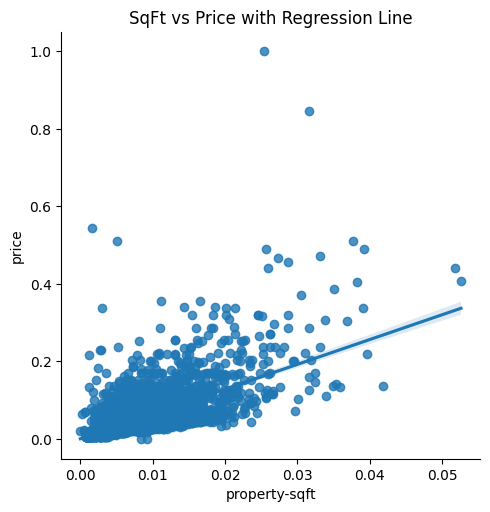

In [93]:
sns.lmplot(data=data_scored, x="property-sqft", y="price")
plt.title("SqFt vs Price with Regression Line")